In [177]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [178]:
data = open('input.txt').read()
alphabet = set([c for c in data])
stoi = {s:i for i,s in enumerate(alphabet)}
itos = {value: key for key, value in stoi.items()}
vocab_size = len(alphabet)
print(f"{vocab_size=}")
def encode(s):
    return [stoi[c] for c in s]

def decode(encoded):
    return ''.join([itos[i] for i in encoded])

encoded = torch.tensor(encode(data), dtype=torch.long)
encoded[:20]

vocab_size=65


tensor([ 1,  6, 56, 37, 63, 35, 40,  6, 63,  6, 20, 31, 53, 32, 17, 64, 31, 24,
        60, 56])

In [179]:
x = int(0.9 * len(data))
training_data = encoded[:x]
validation_data = encoded[x:]

In [180]:
torch.manual_seed(42)
batch_size = 32
block_size = 2

def get_batch(split):
    data = training_data if split == 'train' else validation_data
    indices = torch.randint(0, data.shape[0] - 1 - block_size, (batch_size,))
    xs = torch.stack([data[i:i+block_size] for i in indices])
    ys = torch.stack([data[i+1:i+block_size+1] for i in indices])
    return xs, ys

xbatch, ybatch = get_batch('train')
xbatch, ybatch

(tensor([[53, 63],
         [53,  6],
         [56, 35],
         [56, 56],
         [ 7, 60],
         [57,  9],
         [41, 17],
         [35, 24],
         [35, 48],
         [60, 33],
         [58, 16],
         [35, 19],
         [63, 35],
         [39, 39],
         [53, 63],
         [60, 53],
         [31, 35],
         [48, 31],
         [45, 60],
         [60, 56],
         [57, 56],
         [33, 63],
         [63, 48],
         [17, 23],
         [31, 35],
         [45, 57],
         [59, 60],
         [53, 45],
         [63, 48],
         [56, 53],
         [37, 35],
         [60, 56]]),
 tensor([[63,  3],
         [ 6, 33],
         [35, 57],
         [56, 59],
         [60, 33],
         [ 9, 31],
         [17, 43],
         [24, 60],
         [48, 57],
         [33, 26],
         [16, 32],
         [19, 26],
         [35, 58],
         [39, 23],
         [63,  6],
         [53, 35],
         [35, 63],
         [31, 56],
         [60, 60],
         [56, 31],
         [

In [181]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets=None):
        logits = self.embeddings(x)
        loss = None
        if targets is not None:            
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return loss, logits

    def generate(self, length):
        result = ''
        context = torch.randint(0, vocab_size, (1,1))
        for _ in range(length):
            _, logits = self(context)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            sample = torch.multinomial(probs, 1, replacement=True)
            context = torch.cat([context, sample], dim=1)
            if context.shape[0] >= block_size:
                context = context[1:]
            result += itos[sample.item()]
        return result


In [182]:
m = BigramLanguageModel()
m.generate(10)

torch.Size([1, 1])


'nLJWYGoti '

In [183]:
model = BigramLanguageModel()
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
losses = []

for step in range(200000):
    xbatch, ybatch = get_batch('train')
    loss, _ = model(xbatch, targets=ybatch)

    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    if step % 1000 == 0:
        print(f'step {step} loss {loss.item()}')


step 0 loss 4.6788763999938965
step 1000 loss 2.779974937438965
step 2000 loss 2.39630126953125
step 3000 loss 2.2386107444763184
step 4000 loss 2.440312147140503
step 5000 loss 2.343170642852783
step 6000 loss 2.087421178817749
step 7000 loss 2.4479689598083496
step 8000 loss 2.6855664253234863
step 9000 loss 2.4716761112213135
step 10000 loss 2.5949459075927734
step 11000 loss 2.1806137561798096
step 12000 loss 2.4052844047546387
step 13000 loss 2.446333408355713
step 14000 loss 2.148827314376831
step 15000 loss 2.429877996444702
step 16000 loss 2.40527081489563
step 17000 loss 2.684915542602539
step 18000 loss 2.6877601146698
step 19000 loss 2.1675825119018555
step 20000 loss 2.2135560512542725
step 21000 loss 2.4597227573394775
step 22000 loss 2.5630080699920654
step 23000 loss 2.483510732650757
step 24000 loss 2.693451166152954
step 25000 loss 2.7856011390686035
step 26000 loss 2.692096710205078
step 27000 loss 2.5742883682250977
step 28000 loss 2.135826826095581
step 29000 loss 2

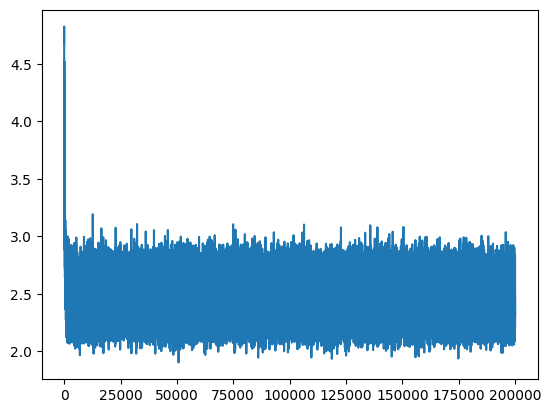

In [184]:
plt.plot(losses)

In [185]:
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            loss, _ = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [186]:
estimate_loss()

{'train': tensor(2.4613), 'val': tensor(2.5091)}

In [187]:
print(model.generate(100))

torch.Size([1, 1])

S:
ARI me
LO:

CAMy, ild bl t herimexen; st toter t sh MPHE:
Bes, hesemoomy m

ROxige s trrt whethi
